# Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import glob
import json
import h5py
import xarray as xr
from tqdm import tqdm
import cv2
import rioxarray

2023-02-03 11:16:42.834669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 11:16:42.834705: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tensorflow import keras
print(keras.__version__)

2.8.0


In [3]:
import tensorflow as tf
print(tf.__version__)

2.8.0


# Define directories

In [4]:
os.listdir()

['wetransfer_cnn_v2_weights-47-0-17-hdf5_2023-01-06_1307.zip',
 'cnn_v2_weights.47-0.17.hdf5',
 '.ipynb_checkpoints',
 'CNN_Spekboom.ipynb',
 '00_scale_raw_to_255.R',
 '00_tensorflow_functions.R',
 '02_unet_softmax_varsize_tfdataset_v3.R',
 '03_unet_apply_v2.R',
 '03_unet_apply_v5_oneMission.R',
 '04_aggregate_predictions_v1.R',
 '1B_tile_adhoc_files_v3.R',
 '1C_removebrokentiles.R',
 '1_tile_original_files_v3.R',
 'Kuzuko_CNN.ipynb',
 'OneDrive_1_2-2-2023.zip',
 '20230127_weights.33-0.12.hdf5',
 'CNN_202204_weights.11-0.22.hdf5',
 'Tiles',
 'Predictions',
 'prediction_output.tif',
 'prediction_output_10mm_Clipped.tif',
 'prediction_output_10mm.tif',
 'prediction_output_20mm_20230127_weights.33-0.12.hdf5.tif',
 'prediction_output_20mm_CNN_202204_weights.11-0.22.hdf5.tif']

# Presettings

In [5]:
res = 128
chnl = 3

# Load model

In [6]:
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    result = (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return result

def bce_dice_loss(y_true, y_pred):
    result = tf.keras.losses.binary_crossentropy(y_true, y_pred) + (1. - dice_coef(y_true, y_pred))
    return result


model = tf.keras.models.load_model('CNN_202204_weights.11-0.22.hdf5', compile=False)


model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss=bce_dice_loss, metrics=[dice_coef])

2023-02-03 11:17:12.886217: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/c4ubuntu/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-03 11:17:12.886253: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-03 11:17:12.886272: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c4ubuntu): /proc/driver/nvidia/version does not exist
2023-02-03 11:17:12.886944: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Prediction

In [7]:
image_dir = "Tiles/"
target_tif = glob.glob(os.path.join(image_dir, "*.tif"))

In [8]:
target_tif

['Tiles/Kuzuko Block A-2_tile-100.tif',
 'Tiles/A29_202010_high_res.tif',
 'Tiles/A28_202010_high_res.tif',
 'Tiles/Kuzuko Block A-15.tif',
 'Tiles/A28_202010_high_res_clipped.tif']

In [9]:
# Load the TIFF file as a xarray dataset
ds = rioxarray.open_rasterio('Tiles/Kuzuko Block A-2_tile-100.tif')
#ds = ds.drop_sel(band=4)
# Get the data as a numpy array and the metadata as a dictionary
bands = ds.values / 255
meta = ds.attrs


# Perform predictions on the raster by dividing it into smaller tiles
tile_size = 128
res = tile_size

ind_col = np.arange(64, np.floor((ds.shape[2] - 64) / 128) * 128, res)
ind_row = np.arange(64, np.floor((ds.shape[1] - 64) / 128) * 128, res)
ind_grid = np.array(np.meshgrid(ind_col, ind_row)).T.reshape(-1, 2)
predictions = np.zeros((ds.shape[0]-2, ds.shape[1], ds.shape[2]))

for i in tqdm(range(ind_grid.shape[0])):
    tile = bands[:, ind_grid[i, 0].astype(int):ind_grid[i, 0].astype(int) + res, ind_grid[i, 1].astype(int):ind_grid[i, 1].astype(int) + res]
    if np.isnan(tile).sum() == 0:
        tile = np.expand_dims(tile, axis=0)
        tile = np.transpose(tile, (0, 2, 3, 1))
        prediction = model.predict(tile)[0]
        #prediction = np.transpose(prediction, (0, 2, 3, 1))
        predictions[:,ind_grid[i, 0].astype(int):ind_grid[i, 0].astype(int) + res, ind_grid[i, 1].astype(int):ind_grid[i, 1].astype(int) + res] = prediction.transpose(2, 0, 1)
   # if i % 10 == 0:
        #print(f'Tile {i} of {ind_grid.shape[0]} processed...')

# Save the predictions as a new xarray dataset
pred_folder = 'Predictions/'
output_file = os.path.join(pred_folder, 'prediction_output_CNN_202204_weights.11-0.22.hdf5.nc')
pred_ds = xr.Dataset({'prediction': (['band', 'y', 'x'], predictions)}, coords={'y': ds.coords['y'], 'x': ds.coords['x']})
pred_ds.attrs = meta
pred_ds.to_netcdf(output_file)
#with rio.open('prediction_output_20mm_CNN_202204_weights.11-0.22.hdf5.tif', 'w', driver='GTiff', height=pred_ds.dims['y'], width=pred_ds.dims['x'], count=pred_ds.dims['band'], dtype=pred_ds.prediction.values.dtype, nodata=0) as out:
 #   out.write(pred_ds.prediction.values)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 961/961 [02:17<00:00,  6.98it/s]


In [10]:
pred_ds.rio.write_crs(ds.rio.crs, inplace=True)

<xarray.Dataset>
Dimensions:      (band: 1, y: 4096, x: 4096)
Coordinates:
  * y            (y) float64 6.332e+06 6.332e+06 ... 6.332e+06 6.332e+06
  * x            (x) float64 3.494e+05 3.494e+05 ... 3.495e+05 3.495e+05
    spatial_ref  int64 0
Dimensions without coordinates: band
Data variables:
    prediction   (band, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  255
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  1
    STATISTICS_STDDEV:   -9999
    _FillValue:          -3.4e+38
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('layer.1', 'layer.2', 'layer.3')

In [11]:
pred_ds.prediction.rio.to_raster('prediction_output_20mm_CNN_202204_weights.11-0.22.hdf5.tif')

ERROR 1: PROJ: proj_create_from_name: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


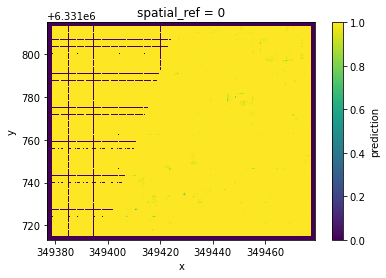

In [12]:
pred_ds.prediction[:,:,:].plot()

In [28]:
# Load the TIFF file as a xarray dataset
ds = xr.open_rasterio('Tiles/A29_202010_high_res.tif')
ds = ds.drop_sel(band=4)
# Get the data as a numpy array and the metadata as a dictionary
bands = ds.values
meta = ds.attrs
fname = os.path.basename('Tiles/A29_202010_high_res.tif')
print(fname)
# Perform predictions on the raster by dividing it into smaller tiles
tile_size = 128
res = tile_size

ind_col = np.arange(64, np.floor((ds.shape[2] - 64) / 128) * 128, res)
ind_row = np.arange(64, np.floor((ds.shape[1] - 64) / 128) * 128, res)
ind_grid = np.array(np.meshgrid(ind_col, ind_row)).T.reshape(-1, 2)
predictions = np.zeros((ds.shape[0], ds.shape[1], ds.shape[2]))

for i in tqdm(range(ind_grid.shape[0])):
    tile = bands[:, ind_grid[i, 0].astype(int):ind_grid[i, 0].astype(int) + res, ind_grid[i, 1].astype(int):ind_grid[i, 1].astype(int) + res]
    if np.isnan(tile).sum() == 0:
        tile = np.expand_dims(tile, axis=0)
        tile = np.transpose(tile, (0, 2, 3, 1))
        prediction = model.predict(tile)[0]
        #prediction = np.transpose(prediction, (0, 2, 3, 1))
        predictions[1,ind_grid[i, 0].astype(int):ind_grid[i, 0].astype(int) + res, ind_grid[i, 1].astype(int):ind_grid[i, 1].astype(int) + res] = prediction.transpose(2, 0, 1)
   # if i % 10 == 0:
        #print(f'Tile {i} of {ind_grid.shape[0]} processed...')

# Save the predictions as a new xarray dataset
pred_folder = 'Predictions/'
output_file = os.path.join(pred_folder, 'prediction_output.nc')
pred_ds = xr.Dataset({'prediction': (['band', 'y', 'x'], predictions)}, coords={'y': ds.coords['y'], 'x': ds.coords['x']})
pred_ds.attrs = meta
pred_ds.to_netcdf(output_file)
with rio.open('prediction_output.tif', 'w', driver='GTiff', height=pred_ds.dims['y'], width=pred_ds.dims['x'], count=pred_ds.dims['band'], dtype=pred_ds.prediction.values.dtype, nodata=0) as out:
    out.write(pred_ds.prediction.values)

/tmp/ipykernel_3790/363499225.py:2: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  ds = xr.open_rasterio('Tiles/A29_202010_high_res.tif')
ERROR 1: PROJ: proj_identify: /home/c4ubuntu/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


A29_202010_high_res.tif


  3%|█████▍                                                                                                                                                                           | 280/9118 [00:39<20:56,  7.03it/s]


KeyboardInterrupt: 

In [121]:
with rio.open('prediction_output.tif', 'w', driver='GTiff', height=pred_ds.dims['y'], width=pred_ds.dims['x'], count=pred_ds.dims['band'], dtype=pred_ds.prediction.values.dtype, nodata=0) as out:
    out.write(pred_ds.prediction.values)

/home/c4ubuntu/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:287: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


In [ ]:
# Load the TIFF file as a raster
with rio.open('Tiles/Kuzuko Block A-2_tile-100.tif') as src:
    meta = src.meta
    bands = src.read()
    fname = os.path.basename(target_tif[ii])

# Perform predictions on the raster by dividing it into smaller tiles
tile_size = 128
res = tile_size

ind_col = np.arange(64, np.floor((ds.shape[2] - 64) / 128) * 128, res)
ind_row = np.arange(64, np.floor((ds.shape[1] - 64) / 128) * 128, res)
ind_grid = np.array(np.meshgrid(ind_col, ind_row)).T.reshape(-1, 2)
predictions = np.zeros((ds.shape, ds.shape[1], ds.shape[2]))

for i in tqdm(range(ind_grid.shape[0])):
    tile = bands[:, ind_grid[i, 0].astype(int):ind_grid[i, 0].astype(int) + res, ind_grid[i, 1].astype(int):ind_grid[i, 1].astype(int) + res]
    if np.isnan(tile).sum() == 0:
        tile = np.expand_dims(tile, axis=0)
        tile = np.transpose(tile, (0, 2, 3, 1))
        prediction = model.predict(tile)[0]
        predictions[:,ind_grid[i, 0].astype(int):ind_grid[i, 0].astype(int) + res, ind_grid[i, 1].astype(int):ind_grid[i, 1].astype(int) + res] = prediction.transpose(2, 1, 0)

# Save the predictions as a new raster file
pred_folder = 'Predictions/'
output_file = os.path.join(pred_folder, 'prediction_output_rasterio.tif')
with rio.open(output_file, 'w', **meta) as dst:
    dst.write(predictions)